<div style="padding:20px;
            color:white;
            margin:10;
            font-size:200%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700"><span style='color:#CDA63A'>|</span> Key takeaways </div>

**Objective**: To predict the price of a house from a dataset of 2930 houses with 79 predictors (such as floor area, construction quality, and no. of rooms). For the data documentation, [click here](https://www.openintro.org/data/index.php?data=ames). 

**Performance of final model**: On average, the house prices predicted by the final model (a lasso-regularized quadratic regression) were incorrect by $14,500 (8% of the mean house price).

# Final model pipeline

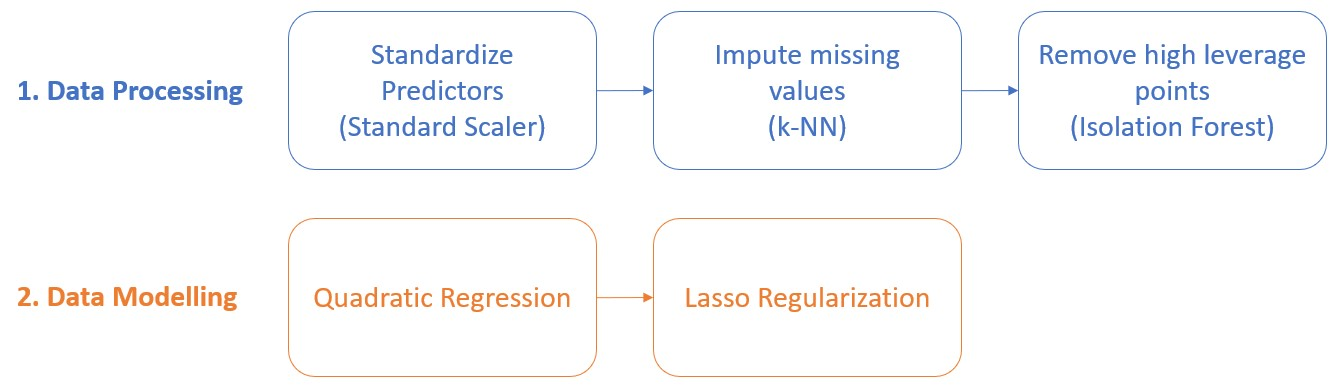

<div style="padding:20px;
            color:white;
            margin:10;
            font-size:200%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700"><span style='color:#CDA63A'>|</span> Importing libraries and the data </div>

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    cross_validate,
    train_test_split,
    validation_curve,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [2]:
#Customize graphing settings
sns.set_theme()
mpl.rcParams["axes.titlelocation"] = "left"
mpl.rcParams["axes.titlesize"] = 20
mpl.rcParams["yaxis.labellocation"] = "center"
mpl.rcParams["axes.labelsize"] = 15
mpl.rcParams["xtick.labelsize"] = 15
mpl.rcParams["ytick.labelsize"] = 15
mpl.rcParams["font.size"] = 18

In [3]:
# Use the Order column (unique identifier for each house) as the row index
houses_data = pd.read_csv("ames_houses_data.csv", index_col="Order")
X = houses_data.drop(columns=["price"])
y = houses_data.loc[:, "price"]

print(f"X size: {X.shape[0]} observations, {X.shape[1]} predictors")

X size: 2930 observations, 80 predictors


For simplicity, we only used countinuous, discrete, and ordinal predictors to train my models. Hence, we removed all of the nominal predictors from the dataset.

In [4]:
X = X.select_dtypes(include="number")

# Manually remove nominal columns encoded with integers
X.drop(columns=["MS.SubClass", "Mo.Sold", "PID"], inplace=True)

print(f"X size after removing unwanted predictors: {X.shape[0]} observations, {X.shape[1]} predictors")

X size after removing unwanted predictors: 2930 observations, 34 predictors


We then split the dataset into a training set (80%) and a test set (20%). 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"X_train size: {X_train.shape[0]} observations, {X_train.shape[1]} predictors")
print(f"X_test size: {X_test.shape[0]} observations, {X_test.shape[1]} predictors")

X_train size: 2344 observations, 34 predictors
X_test size: 586 observations, 34 predictors


<div style="padding:20px;
            color:white;
            margin:10;
            font-size:200%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700"><span style='color:#CDA63A'>|</span> Exploring the data </div>

# Distributions of the variables

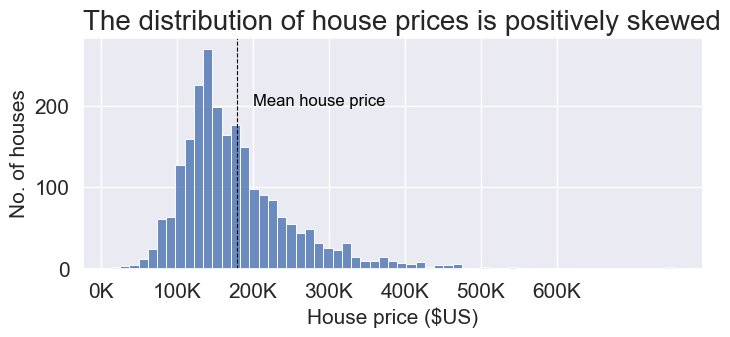

In [6]:
# Distribution of house prices (the target)
fig, ax = plt.subplots(figsize=(8,3))
sns.histplot(y_train, alpha=.8)
plt.title("The distribution of house prices is positively skewed")
plt.xlabel("House price ($US)")
plt.ylabel("No. of houses")
plt.axvline(x=np.mean(y_train), color="black", linestyle="dashed", lw=0.8) 
plt.annotate("Mean house price", (200000, 200), fontsize=12, color="black")

x_ticks = np.arange(0, 700_000, 100_000)
ax.set_xticks(ticks=x_ticks, labels=[str(tick//1000) + "K" for tick in x_ticks])

plt.show()

The distribution of house prices is **positively skewed** due to a few very expensive houses.

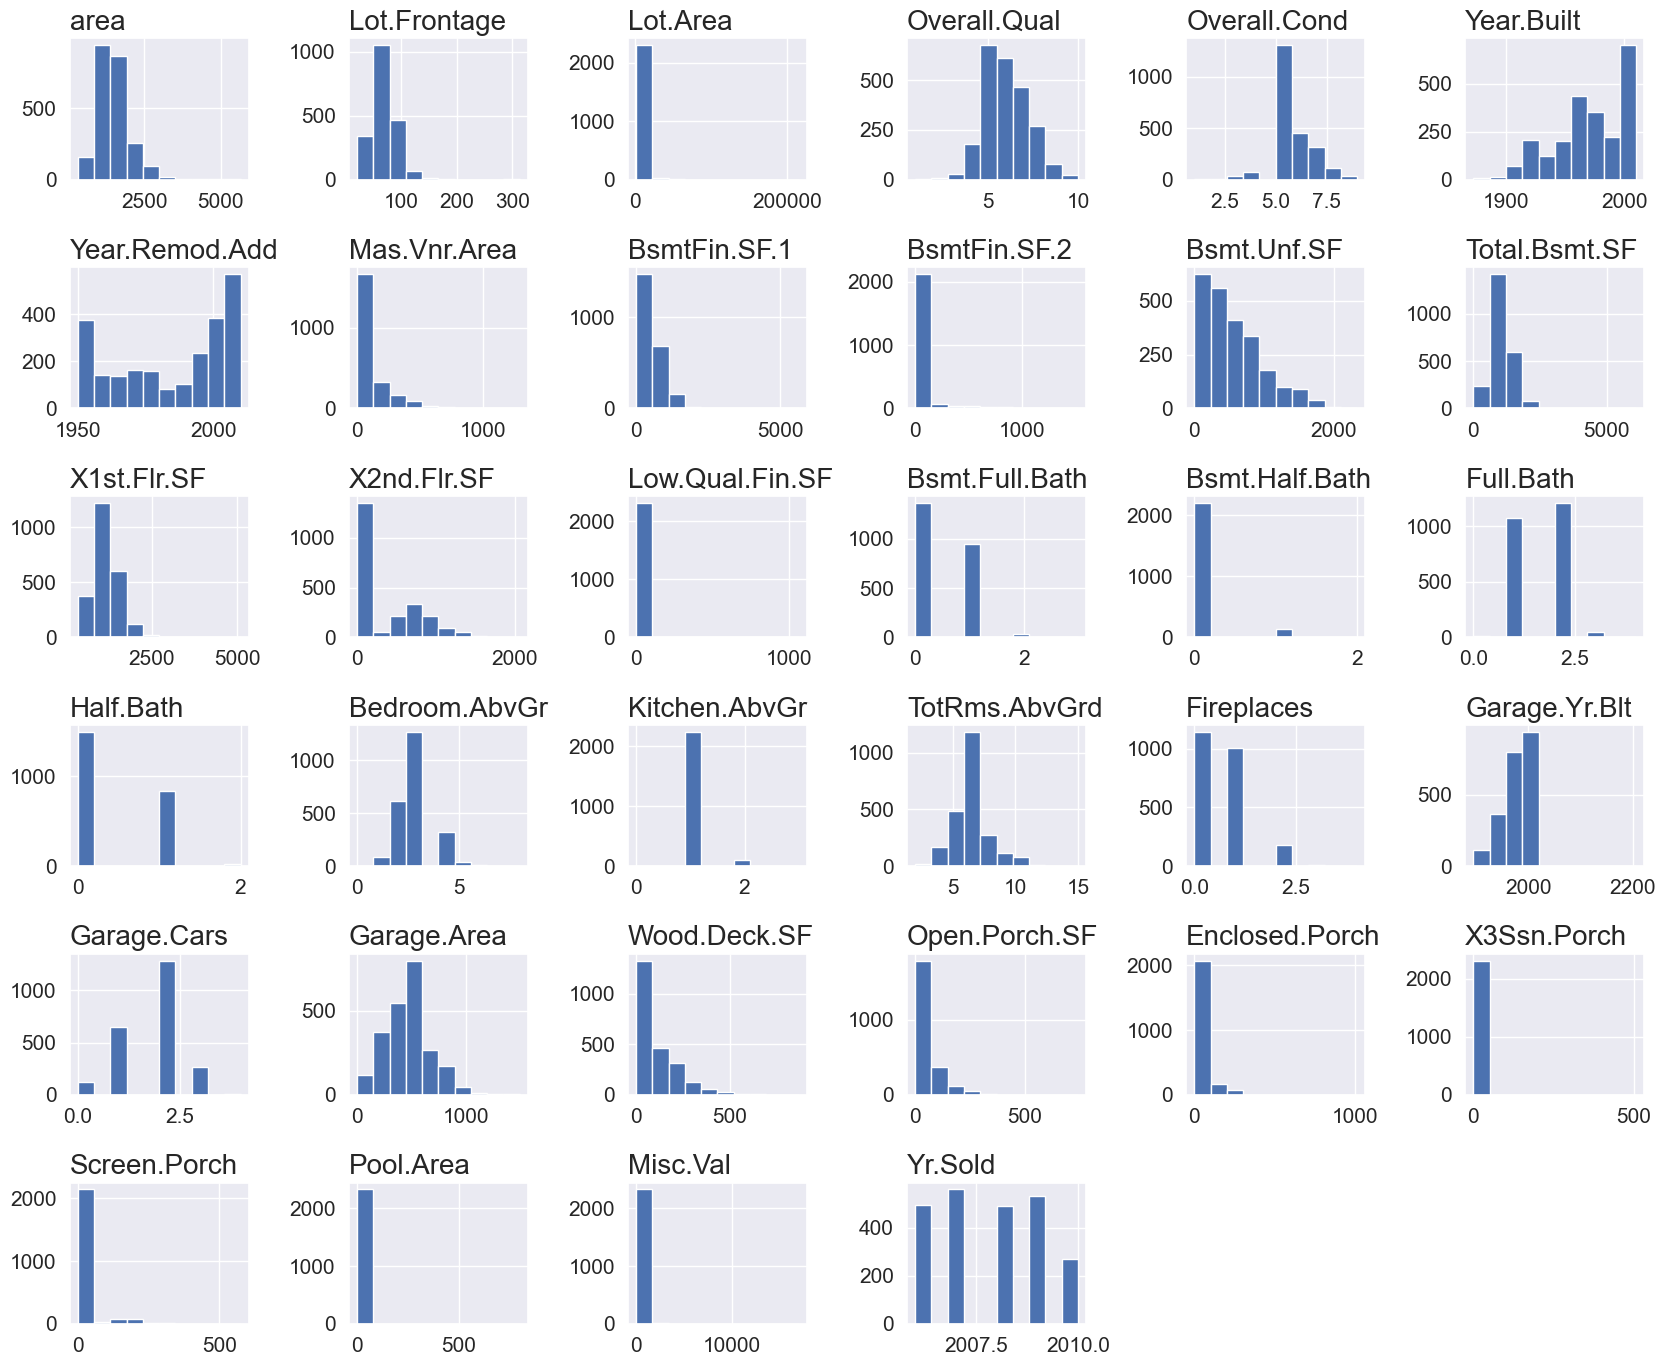

In [7]:
fig = X_train.hist(figsize=(17, 14))
plt.tight_layout()
plt.show()

Many of the predictors (Pool.Area, Screen.Porch) are 0 for most of the houses. For example:
- **Pool.Area**: Pool area 
- **Screen.Porch**: Screen porch area

This is because most houses do not have these amenities.

# Correlations between variables

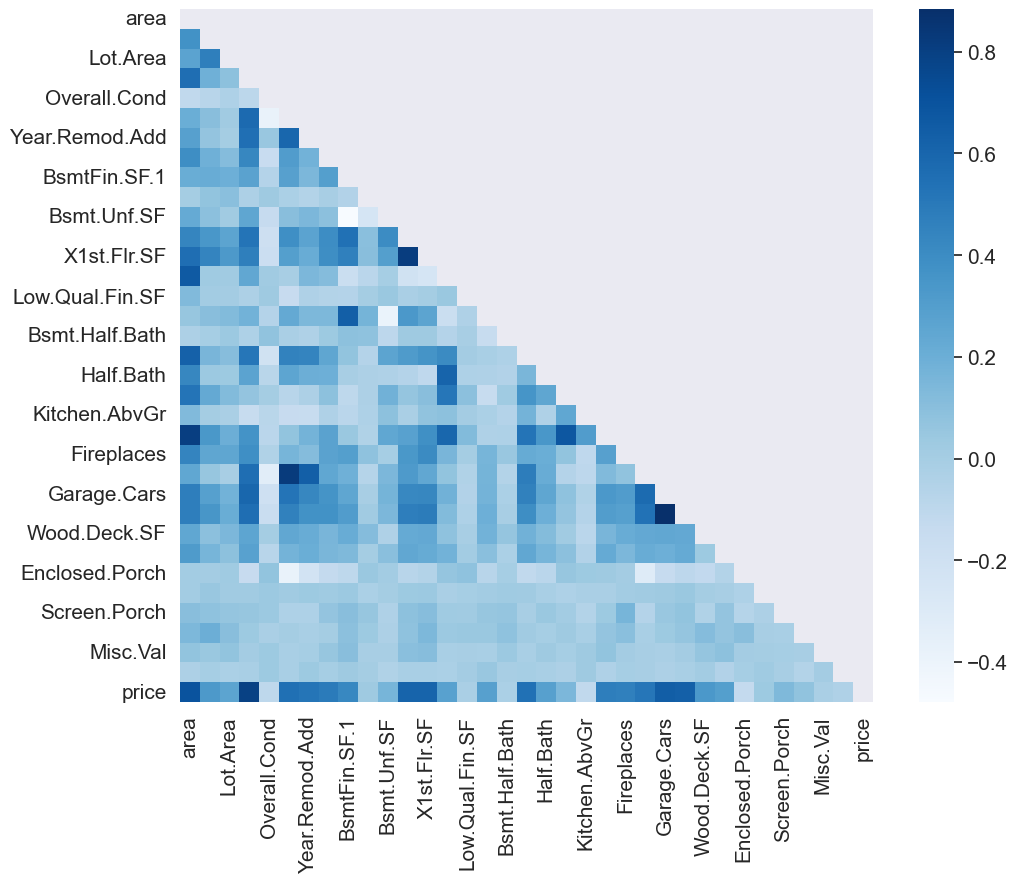

In [8]:
correlation_matrix = pd.concat([X_train, y_train], axis=1).corr()
lower_triangle_mask = np.tril(np.ones(correlation_matrix.shape), k = -1).astype(bool)
# Replace all values above the lower triangle with NaN
correlation_matrix = correlation_matrix.where(lower_triangle_mask)

with sns.axes_style("dark"):
    f, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(correlation_matrix, cmap="Blues", square=True);

There are a few variables that are strongly correlated with each other (<font color='#083d7f'>**dark cells**</font>). We will now identify these variables.

## Correlations with the target (house price)

In [9]:
most_positive = correlation_matrix.loc["price"].sort_values(ascending=False)[0:5]
print(
    f"The {len(most_positive)} predictors that were most positively correlated with house price were:\n",
    most_positive,
    "\n",
    sep="",
)

most_negative = correlation_matrix.loc["price"].sort_values(ascending=True)[0:1]
print(
    f"The predictor that was most negatively correlated with house price was:\n",
    most_negative,
    sep="",
)

The 5 predictors that were most positively correlated with house price were:
Overall.Qual     0.795298
area             0.698315
Garage.Cars      0.644304
Garage.Area      0.633106
Total.Bsmt.SF    0.612256
Name: price, dtype: float64

The predictor that was most negatively correlated with house price was:
Enclosed.Porch   -0.130722
Name: price, dtype: float64


- **Overall.Qual**: Quality of the construction materials and workmanship on a scale of 1 to 10. 
- **area**: The total living area above the ground. 
- **Garage.Cars**: No. of cars that can fit in the garage. 
- **Total.Bsmt.SF**: The area of the basement.
- **Garage.Area**: Area of the garage.

## Correlations between predictors

In [10]:
most_positive = correlation_matrix.stack().sort_values(ascending=False)[0:5]
print(
    f"The {len(most_positive)} predictor pairs that were most positively correlated were:\n",
    most_positive,
    "\n",
    sep="",
)

most_negative = correlation_matrix.stack().sort_values(ascending=True)[0:1]
print(
    f"The predictor pair that was most negatively correlated was:\n",
    most_negative,
    sep="",
)

The 5 predictor pairs that were most positively correlated were:
Garage.Area    Garage.Cars      0.883871
Garage.Yr.Blt  Year.Built       0.824690
X1st.Flr.SF    Total.Bsmt.SF    0.813946
TotRms.AbvGrd  area             0.806434
price          Overall.Qual     0.795298
dtype: float64

The predictor pair that was most negatively correlated was:
Bsmt.Unf.SF  BsmtFin.SF.1   -0.47883
dtype: float64


The area of a house's garage and the number of cars it can fit are highly correlated.

Collinear predictors (**multicollinearity**) increase the uncertainty in the estimated regression coefficients, which decreases how interpretable the models are. However, they do not affect prediction accuracy. For simplicity, we will not modify them in this analysis.

<div style="padding:20px;
            color:white;
            margin:10;
            font-size:200%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700"><span style='color:#CDA63A'>|</span> Processing the data </div>

Each step in the data processing can be represented by a scikit-learn **`Transformer`** object. These transfromers can be assembled into a **`Pipeline`** object, which can be used to apply all of the data processing steps to new data in one method call.

# Data standardization

We will use scikit-learn's **`StandardScaler`** transformer to standardize each predictor variable to a mean of 0 and a standard deviation of 1. This will improve the training speed and performance of the regression models.

# Handling missing data

Regression models cannot be trained on data with missing values. The simplest solution is to delete observations with missing values. But observations with a few missing predictor values still have a lot of information in their other predictor values. So a better option is to replace missing data with a best guess based on other data in the dataset (**data imputation**). 

We will use the **`KNNImputer`** transformer to impute missing data. For each observation with missing predictor values, k-Nearest Neighbors:
1. Identifies the k observations that are closest to it in the predictor space.
2. Takes the averages of their predictor values and uses them to impute the missing values.  

# Data processing pipeline

In [11]:
data_processing = make_pipeline(StandardScaler(), KNNImputer())

# Removing high leverage points

**High leverage points (HLPs)** are observations that are far away from other observations in the predictor space. They can worsen the fit on the rest of the observations. We will use the **`IsolationForest`** estimator to identify HLPs, then we will manually remove them. Technically, this should be a step in the data processing pipeline, but scikit-learn does not support HLP removal.

In [12]:
def remove_HLP(
    pred_HLP: np.ndarray, X: pd.DataFrame, y: pd.Series
) -> (pd.DataFrame, pd.Series):
    """
        Removes outliers from the provided dataset.
        Parameters:
            pred_HLP: An array of 0s (observation is not an outlier) and 1s (observation is an outlier).
            X: the predictors dataframe to remove outliers from.
            y: the target series to remove outliers from.
        Returns: 
            X_no_outliers: X with outliers removed.
            y_no_outliers: y with outliers removed.
    """
    
    num_HLP = np.count_nonzero((pred_HLP == -1))
    perc_HLP = num_HLP / len(y_train) * 100
    print(f"{perc_HLP:.2f}% of the houses were identified as HLPs and removed.")

    not_HLP = pred_HLP == 1
    return (X[not_HLP], y[not_HLP])

In [13]:
X_train_old = X_train  # keep a copy to plot the removed HLPs
contamination_value=0.004
hlp_pipe = make_pipeline(
    data_processing, IsolationForest(random_state=42, contamination=contamination_value)
)
hlp_pipe.fit(X_train)
X_train, y_train = remove_HLP(hlp_pipe.predict(X_train), X_train, y_train)

0.43% of the houses were identified as HLPs and removed.


We used **principal component analysis (PCA)** to estimate an appropriate HLP classification threshold (the "contamination" parameter in `IsolationForest`). PCA summarizes the variance in the predictor space in a lower-dimensional principal component space. Hence, high leverage points are also isolated in the principal component space, where they can be visually identified.

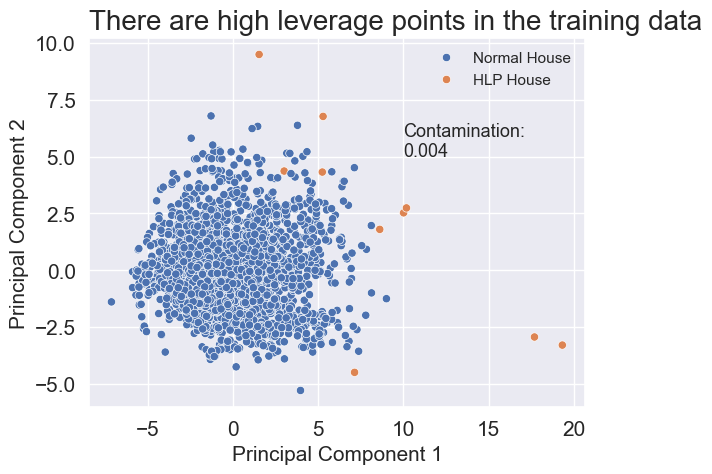

In [14]:
pca_pipe = make_pipeline(data_processing, PCA(n_components=2))
pc_scores = pd.DataFrame(pca_pipe.fit_transform(X_train_old), columns=["PC1", "PC2"])
is_HLP = pd.Series((hlp_pipe.predict(X_train_old) == -1), name="is_HLP")
pc_scores = pd.concat([pc_scores, is_HLP], axis=1)

ax = sns.scatterplot(data=pc_scores, x="PC1", y="PC2", hue="is_HLP")
plt.title("There are high leverage points in the training data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
handles, labels = ax.get_legend_handles_labels()
plt.annotate(f"Contamination:\n{contamination_value}", (10,5), fontsize=13)
plt.legend(handles, ["Normal House", "HLP House"], frameon=False)
plt.show()

<div style="padding:20px;
            color:white;
            margin:10;
            font-size:200%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700"><span style='color:#CDA63A'>|</span> Modelling the data </div>

# Linear regression

One of the simplest models we can use to predict the house prices is **multiple linear regression**. It assumes that the target is a linear combination of the predictors. We will now train a multiple linear regression model on the entire training set then fit it on the training set to obtain a residual plot.

In [15]:
linear_pipe = make_pipeline(data_processing, LinearRegression())
linear_pipe.fit(X_train, y_train)
pred_y_train = pd.Series(linear_pipe.predict(X_train), index=X_train.index)
train_residuals = y_train - pred_y_train

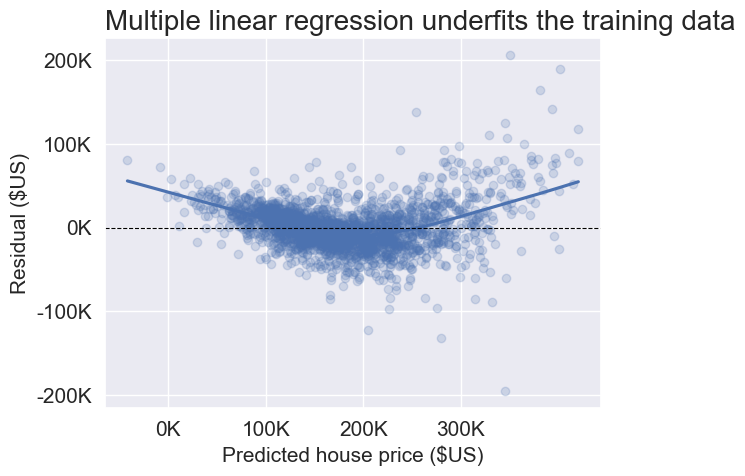

In [16]:
fig, ax = plt.subplots()
sns.regplot(
    x=pred_y_train, y=train_residuals, scatter_kws={"alpha": 0.2}, lowess=True
)  # locally weighted linear regression

plt.axhline(y=0, color="black", linestyle="dashed", lw=0.8) 
plt.title("Multiple linear regression underfits the training data")
plt.xlabel("Predicted house price ($US)")
plt.ylabel("Residual ($US)")

x_ticks = np.arange(0, 400_000, 100_000)
ax.set_xticks(ticks=x_ticks, labels=[str(tick//1000) + "K" for tick in x_ticks])

y_ticks = np.arange(-200_000, 300_000, 100_000)
ax.set_yticks(ticks=y_ticks, labels=[str(tick//1000) + "K" for tick in y_ticks])
plt.show()

The residual plot is curved, which suggests that linear regression underfits the training data.

Since the test set is reserved for the evaluation of our final model, We will use cross-validation to evaluate the multiple linear regression model. We will use the **root mean square error (RMSE)** evaluation metric. Since we will be evaluating many regression models, we will create a function to print the mean RMSEs for each model.

In [17]:
def cv_scores(pipe: Pipeline) -> dict:
    """
    Prints out the mean training set RMSE and mean validation set RMSE from cross validation.
        Parameters:
            pipe: The pipeline to process the data and build a model.
        Returns:
            The output of cross_validate().
    """
    cv_results = cross_validate(
        pipe,
        X_train,
        y_train,
        scoring="neg_root_mean_squared_error",
        return_train_score=True,
        return_estimator=True,
        n_jobs=-1,
    )
    train_scores = -cv_results["train_score"]
    print(
        f"Mean RMSE for training sets: {train_scores.mean():,.2f} ({train_scores.std():,.2f} SD)"
    )
    test_scores = -cv_results["test_score"]
    print(
        f"Mean RMSE for validation sets: {test_scores.mean():,.2f} ({test_scores.std():,.2f} SD)"
    )
    return cv_results

In [18]:
cv_results = cv_scores(linear_pipe)

Mean RMSE for training sets: 26,478.23 (371.98 SD)
Mean RMSE for validation sets: 27,012.96 (1,416.68 SD)


The lower the root mean square error (RMSE), the better the model is. The RMSEs for the training sets and validation sets are very similar, suggesting the model may be underfitting.

# Polynomial regression

To increase model complexity, we will add second-order predictors that are powers and products of the original predictors (**quadratic regression**).

In [19]:
quad_pipe = make_pipeline(
    data_processing, PolynomialFeatures(degree=2), LinearRegression()
)

In [20]:
quad_pipe.fit(X_train, y_train)
quadratic = quad_pipe["linearregression"]
num_coef = len(quadratic.coef_[quadratic.coef_ != 0])
print(f"Number of coefficients: {num_coef}")

Number of coefficients: 630


There are a lot of predictors compared to the number of observations (around 2,000), so we expect the model to overfit.

In [21]:
cv_results = cv_scores(quad_pipe)

Mean RMSE for training sets: 15,950.79 (221.13 SD)
Mean RMSE for validation sets: 5,617,733,476,428,074.00 (7,109,560,467,926,945.00 SD)


Since the score is much higher for the training sets than the validation sets, the model is overfitting.

# Lasso regression

**Lasso regression** restricts the magnitudes (regularizes) of the regression coefficients to prevent overfitting. It can also set coefficients to 0, which removes predictors from the model. The amount of regularization is controlled by a hyperparameter ($\alpha$). 

Hyperparameter values are empirically determined by trying a range of different values and seeing which combinations of hyperparameters yield the lowest prediction errors. This process is called **hyperparameter tuning** and can be performed using `GridSearchCV()`. 

In [22]:
param_grid = {"alpha": np.logspace(1, 3.5, num=10)}
search_pipe = make_pipeline(
    data_processing,
    PolynomialFeatures(degree=2),
    GridSearchCV(
        Lasso(),
        param_grid,
        cv=2,
        scoring="neg_root_mean_squared_error",
        return_train_score=True,
        n_jobs=-1,
    ),
)

In [23]:
cv_results = cv_scores(search_pipe)

Mean RMSE for training sets: 20,284.13 (594.46 SD)
Mean RMSE for validation sets: 22,040.81 (1,493.03 SD)


The mean score on the validation set is the highest out of all the models tested so far, indicating that this is the best model so far.

We used the code below to plot the **validation curves**. We used them to adjust the range of alpha values to test. In the plot, we checked that each validation curve had a peak. A curve with no peak meant that the best alpha value was outside the range of values tested, so we increased the range and re-ran the cross-validation.

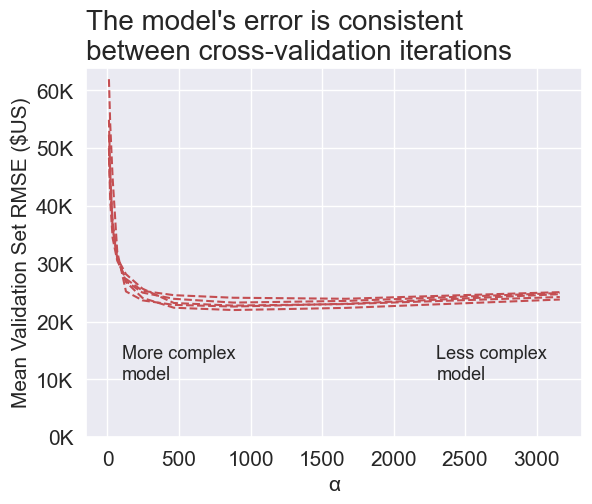

In [24]:
fig, ax = plt.subplots()
search_pipes = cv_results["estimator"]
for search_pipe in search_pipes:
    search = search_pipe["gridsearchcv"]
    valid_mean = -search.cv_results_["mean_test_score"]

    ax.plot(param_grid["alpha"], valid_mean, "r--", label="Validation Score")

plt.title(f"The model's error is consistent \nbetween cross-validation iterations")
plt.xlabel("α")
plt.ylabel(f"Mean Validation Set RMSE ($US)")
plt.annotate("More complex\nmodel", (100, 10_000), fontsize=13)
plt.annotate("Less complex\nmodel", (2_300, 10_000), fontsize=13)
ticks = np.arange(0, 70_000, 10_000)
ax.set_yticks(ticks=ticks, labels=[str(tick // 1000) + "K" for tick in ticks])
plt.show()

Since the quadratic lasso model performs well, we will now train it on the entire training set, then evaluate it using the test set.

In [25]:
param_grid = {"alpha": np.logspace(1, 3.5, num=10)}
search_pipe = make_pipeline(
    data_processing,
    PolynomialFeatures(degree=2),
    GridSearchCV(
        Lasso(),
        param_grid,
        cv=5,
        scoring="neg_root_mean_squared_error",
        return_train_score=True,
        n_jobs=-1,
    ),
)

search_pipe.fit(X_train, y_train)
search = search_pipe["gridsearchcv"]

In [26]:
best_param = search.best_params_["alpha"]
train_mean = -search.cv_results_["mean_train_score"]
train_std = search.cv_results_["std_train_score"]
valid_mean = -search.cv_results_["mean_test_score"]
valid_std = search.cv_results_["std_test_score"]

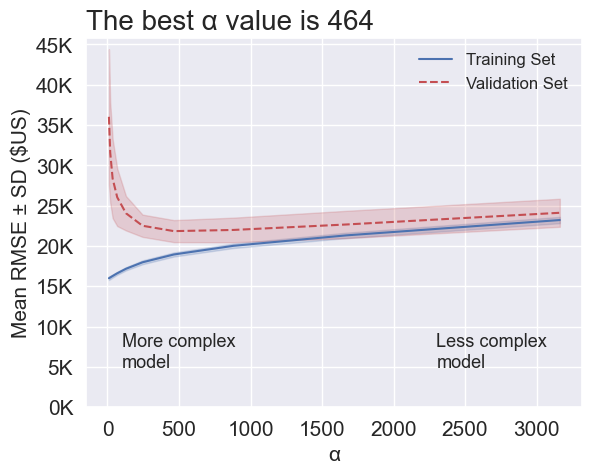

In [34]:
fig, ax = plt.subplots()
ax.plot(param_grid["alpha"], train_mean, "b-", label="Training Set")
plt.fill_between(
    param_grid["alpha"],
    train_mean - train_std,
    train_mean + train_std,
    color="b",
    alpha=0.2,
)
ax.plot(param_grid["alpha"], valid_mean, "r--", label="Validation Set")
plt.fill_between(
    param_grid["alpha"],
    valid_mean - valid_std,
    valid_mean + valid_std,
    color="r",
    alpha=0.2,
)

plt.title(f"The best α value is {int(best_param)}")
plt.xlabel("α")
plt.ylabel(f"Mean RMSE ± SD ($US)")
plt.legend(frameon=False, fontsize=12)
plt.annotate("More complex\nmodel", (100, 5_000), fontsize=13)
plt.annotate("Less complex\nmodel", (2_300, 5_000), fontsize=13)
ticks = np.arange(0, 50_000, 5_000)
ax.set_yticks(ticks=ticks, labels=[str(tick // 1_000) + "K" for tick in ticks])
plt.show()

**Overfitting**: At low alpha values (low regularization), the lasso model overfits the training data (low <font color='#6283bc'>**training set RMSE**</font>, high <font color='#c44e52'>**validation set RMSE**</font>).  

**Underfitting**: At high alpha values (high regularization), the lasso model underfits the training data (high <font color='#6283bc'>**training set RMSE**</font>, high <font color='#c44e52'>**validation set RMSE**</font>). 

In [28]:
lasso_pipe = make_pipeline(
    data_processing,
    PolynomialFeatures(degree=2),
    Lasso(alpha=search.best_params_["alpha"]),
)

In [29]:
lasso_pipe.fit(X_train, y_train)
lasso = lasso_pipe["lasso"]
num_coef = len(lasso.coef_)
num_zero_coef = len(lasso.coef_[lasso.coef_ == 0])
print(f"No. of non-zero coefficients: {(num_coef - num_zero_coef)}")
print(f"Percentage of coefficients removed: {int(num_zero_coef / num_coef * 100)}%")

No. of non-zero coefficients: 151
Percentage of coefficients removed: 76%


Unlike quadratic regression, quadratic lasso regression does not overfit the data because the regularization removes many of the predictors. 

<div style="padding:20px;
            color:white;
            margin:10;
            font-size:200%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700"><span style='color:#CDA63A'>|</span> Evaluating the final model </div>

In [36]:
# Use the outlier detection model that was trained on the training set
# to predict outliers in the test set, then remove them
X_test, y_test = remove_HLP(hlp_pipe.predict(X_test), X_test, y_test)

pred_y_test = pd.Series(lasso_pipe.predict(X_test), index=X_test.index)
print(f"Test set RMSE score: {np.sqrt(mean_squared_error(y_test, pred_y_test)):,.2f}")

0.00% of the houses were identified as HLPs and removed.
Test set RMSE score: 21,867.05


The test set RMSE is similar to the average validation set RMSE, which suggests the model did not overfit the training set.

In [37]:
mean_abs_error = mean_absolute_error(y_test, pred_y_test)
avg_house_price = y_test.mean()

print(f"Test set MAE score: {mean_abs_error:,.2f}")
print(f"MAE as percentage of mean house price: {mean_abs_error / avg_house_price * 100:.0f}%")

Test set MAE score: 14,506.97
MAE as percentage of mean house price: 8%


On average, the house prices predicted by this model are **incorrect by $14,500** (8% of the mean house price). 